In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import logging
import numpy as np
from tqdm import tqdm
from seaborn import kdeplot
import matplotlib.pyplot as plt

In [3]:
from simulator.lob import OrderBookSimulator
from scripts.utils.data_loading import get_data_file_paths

In [4]:
logging.getLogger().setLevel(logging.ERROR)

In [202]:
# simualation parameters
DATA_ROOT = '../data/onetick/processed_3/AAPL'
IMPACT_PARAM = 10 ** 8  # large values execute against historic orders
DURATION = 20 * 60  # in seconds
SAMPLING_FREQUENCY = 5  # in seconds, dicated by LOB data
NUM_PERIODS = int(DURATION / SAMPLING_FREQUENCY)
BREAK_PERIOD = 2 * NUM_PERIODS # int(NUM_PERIODS / 2)

# almgren-chris parameters
PLACEMENT_FREQUENCY = 6
ORDER_SIZE = 100
TRADE_SIZE = 2000

In [123]:
simulation_periods = get_data_file_paths(DATA_ROOT)

In [194]:
def num_assets(t, X, kappa, tau=SAMPLING_FREQUENCY, T=DURATION):
    tau = tau / T
    t = t / T
    T = 1.0
    return X * (2 * np.sinh(0.5 * kappa * tau) / np.sinh(kappa * T)) * np.cosh(kappa * (T - t))

In [279]:
AC_FREQ = 60
t = np.arange(1, DURATION + 1, AC_FREQ)
n = num_assets(t, TRADE_SIZE, 5, tau=AC_FREQ)
n = TRADE_SIZE * n / sum(n)
sum(n)

1999.9999999999989

Text(0.5, 0, 'Time (Seconds)')

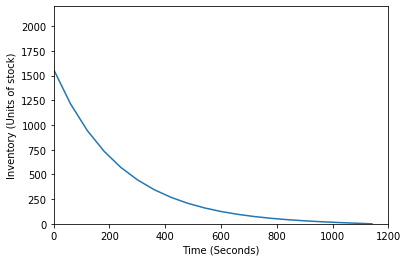

In [280]:
plt.plot(t, TRADE_SIZE - np.cumsum(n))
plt.ylim(0, 1.1 * sum(n))
plt.xlim(0, DURATION)
plt.ylabel('Inventory (Units of stock)')
plt.xlabel('Time (Seconds)')

Text(0.5, 0, 'Time (Seconds)')

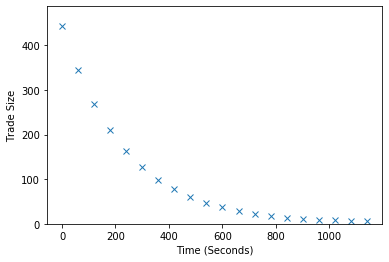

In [281]:
plt.plot(t, n, 'x')
plt.ylim(0, 1.1 * max(n))
plt.ylabel('Trade Size')
plt.xlabel('Time (Seconds)')

### Strategy which places a market sell order every PLACEMENT_FREQUENCY periods

In [81]:
calc_midprice = lambda x: (x.BID_PRICE.max() + x.ASK_PRICE.min()) / 2

In [82]:
def almgren_chris(sim_data_path, order_size=ORDER_SIZE, num_periods=NUM_PERIODS, impact_param=IMPACT_PARAM, placement_frequency=PLACEMENT_FREQUENCY, break_period=BREAK_PERIOD):
    
    try:
        
        # set up LOB simulator
        order_book_file = os.path.join(sim_data_path, 'ob.feather')
        trades_file = os.path.join(sim_data_path, 'trades.feather')
        LOB = OrderBookSimulator(order_book_file, trades_file, impact_param)

        # we will save our trade data to these lists
        order_list = []
        midprice_series = []

        for period in range(0, num_periods):

            if period == break_period:
                break
            
            # advance state
            ob, trds, executed_orders, active_limit_order_levels = LOB.iterate()

            # place sell order
            if not (period % placement_frequency):
                LOB.place_market_sell_order(order_size)

            # save data
            midprice_series.append(calc_midprice(ob))
            order_list += executed_orders
            
    except:
        
        order_list = []
        midprice_series = []
    
    return (order_list, midprice_series)

In [83]:
import multiprocessing as mp

with mp.Pool(max(1, mp.cpu_count() - 1)) as pool:
    pool_results = pool.map(almgren_chris, simulation_periods)

In [10]:
def calculate_shortfall(pool_results):
    ALL_DATA = {}
    for idx, res in enumerate(pool_results):
        if len(res[0]) == 0:
            continue
        ALL_DATA[idx] = {'price_series': res[1], 'executed_orders': res[0]}
    
    shortfall_results = []
    for sim_data_path, sim_results in ALL_DATA.items():
        vol_weighted_price_sum = sum([order['volume'] * order['price'] for order in sim_results['executed_orders']])   
        total_volume = sum([order['volume'] for order in sim_results['executed_orders']])
        vwap = vol_weighted_price_sum / total_volume
        initial_price = sim_results['price_series'][0]
        shortfall = 100 * (vwap - initial_price) / initial_price
        shortfall_results.append(shortfall)
    
    return shortfall_results

In [61]:
shortfall_very_fast = calculate_shortfall(pool_results)
very_fast_pool_results = pool_results

In [70]:
shortfall_fast = calculate_shortfall(pool_results)

In [86]:
shortfall_slow = calculate_shortfall(pool_results)
slow_pool_results = pool_results

(-0.5, 0.5)

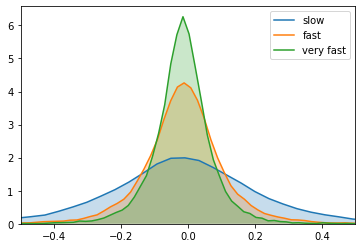

In [87]:
kdeplot(shortfall_slow, shade=True, label='slow')
kdeplot(shortfall_fast, shade=True, label='fast')
kdeplot(shortfall_very_fast, shade=True, label='very fast')
plt.xlim((-0.5, 0.5))

In [73]:
very_fast_mean = np.mean(shortfall_very_fast)
very_fast_std = np.std(shortfall_very_fast)
very_fast_se = very_fast_std / np.sqrt(len(shortfall_very_fast))
print('VERY FAST EXECUTION')
print('Mean Shortfall: %.4f bps +/- %.4f bps' % (100 * very_fast_mean, 100 * very_fast_se))
print('StDev Shortfall: %.4f%%' % very_fast_std)

VERY FAST EXECUTION
Mean Shortfall: -1.6969 bps +/- 0.0652 bps
StDev Shortfall: 0.0919%


In [74]:
fast_mean = np.mean(shortfall_fast)
fast_std = np.std(shortfall_fast)
fast_se = fast_std / np.sqrt(len(shortfall_fast))
print('FAST EXECUTION')
print('Mean Shortfall: %.4f bps +/- %.4f bps' % (100 * fast_mean, 100 * fast_se))
print('StDev Shortfall: %.4f%%' % fast_std)

FAST EXECUTION
Mean Shortfall: -1.4192 bps +/- 0.0909 bps
StDev Shortfall: 0.1281%


In [88]:
slow_mean = np.mean(shortfall_slow)
slow_std = np.std(shortfall_slow)
slow_se = slow_std / np.sqrt(len(shortfall_slow))
print('SLOW EXECUTION')
print('Mean Shortfall:  %.4f bps +/-  %.4f bps' % (100 * slow_mean, 100 * slow_se))
print('StDev Shortfall:  %.4f%%' % slow_std)

SLOW EXECUTION
Mean Shortfall:  -1.5244 bps +/-  0.1843 bps
StDev Shortfall:  0.2592%


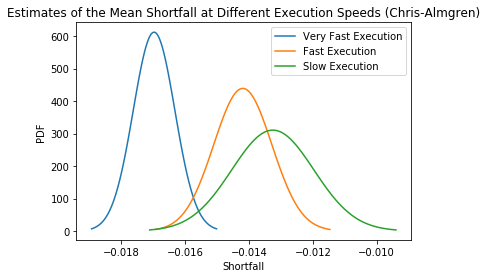

In [77]:
import scipy.stats as stats
import math

mu = very_fast_mean
sigma = very_fast_se
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Very Fast Execution')
mu = fast_mean
sigma = fast_se
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Fast Execution')
mu = slow_mean
sigma = slow_se
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Slow Execution')
plt.title('Estimates of the Mean Shortfall at Different Execution Speeds (Chris-Almgren)')
plt.ylabel('PDF')
plt.xlabel('Shortfall')
plt.legend()
plt.show()